In [366]:
import sys
import os
import pickle
from collections import Counter
import random
import glob
import scipy.stats as stats

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

from gensim.models import Word2Vec
from sklearn import cluster,metrics
from sklearn.preprocessing import StandardScaler, Normalizer
import mygene
from nxontology.imports import from_file


## Summary of cluster enrichment analysis

The cluster enrichment analysis aims to help interpret the results of the disease clustering model. We want to know what annotations are disproportionaly shared amongst diseases within clusters; this may help explain why those diseases are clustered.

In [2]:
gard2gene = pd.read_csv("../data/raw/gard2gene.csv")
gard2hpo = pd.read_csv("../data/raw/gard2hpo.csv")

In [365]:
gard2gene

,GARD_ID,GARD_Disease,Disease_Gene_Association,Gene_Symbol,HGNC,Gene_ID
0,GARD:0004235,Partington syndrome,Disease-causing germline mutation(s) in,ARX,18060,170302.0
1,GARD:0010867,Familial multiple trichoepithelioma,Disease-causing germline mutation(s) in,CYLD,2584,1540.0
2,GARD:0012478,Bleeding disorder due to P2RY12 defect,Disease-causing germline mutation(s) in,P2RY12,18124,64805.0
3,GARD:0002257,Autosomal dominant partial epilepsy with audit...,Disease-causing germline mutation(s) in,RELN,9957,5649.0
4,GARD:0000848,BehÃ§et disease,Major susceptibility factor in,KLRC4,6377,8302.0
...,...,...,...,...,...,...
6466,GARD:0006877,Leigh syndrome,Disease-causing germline mutation(s) in,NDUFA2,7685,4695.0
6467,GARD:0006637,Hereditary spastic paraplegia,Disease-causing germline mutation(s) in,C19ORF12,25443,83636.0
6468,GARD:0012733,Rare hereditary disease with peripheral neurop...,Disease-causing germline mutation(s) in,NDUFA9,7693,4704.0
6469,GARD:0007628,Severe combined immunodeficiency,Disease-causing germline mutation(s) in,DCLRE1C,17642,64421.0


In [3]:
geneid2sym = {int(i):v for i,v in zip(gard2gene['Gene_ID'],gard2gene['Gene_Symbol']) if not pd.isna(i)}

In [4]:
#Load the knowledge graph
with open("../data/processed/disease_ontograph.pkl", 'rb') as f:
    disease_ontograph = pickle.load(f)
    #Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

In [5]:
with open("../data/processed/ordo_semantic_similarity_within_cluster.pkl", 'rb') as f:
    within_cluster_sim = pickle.load(f)
    
within_cluster_dict = {}
for cluster_sim in within_cluster_sim:
    clust, clust_sim = list(cluster_sim.items())[0]
    within_cluster_dict[clust] = np.mean(list(clust_sim.values()))

In [6]:
##Load the embedding model in case
N = 250
L = 250
D = 32 
K_dim = 20
embedding_file = "../data/embeddings/ontograph_embed_N{0}_L{1}_D{2}_K{3}.model".format(N,L,D,K_dim)
model = Word2Vec.load(embedding_file)
disease_vectors = model.wv[diseases]
standard_vectors = StandardScaler().fit_transform(disease_vectors)
normalized_vectors = Normalizer().fit_transform(standard_vectors)

In [7]:
#Load the cluster model
m_file = "../data/clusters/kmeans/ontograph_embed_N{0}_L{1}_D{2}_K{3}_KMEANS_KOPT37.pkl".format(N,L,D,K_dim)
with open(m_file, 'rb') as f:
    cluster_model = pickle.load(f)
    
cluster_map = {dis:cluster_model.labels_[i] for i,dis in enumerate(diseases)}

In [8]:
gard_diseases = pd.concat([gard2gene[['GARD_ID','GARD_Disease']],gard2hpo[['GARD_ID','GARD_Disease']]]).drop_duplicates()

In [9]:
gard_diseases['Cluster'] = [cluster_map[i] for i in gard_diseases['GARD_ID']]

In [10]:
gard_diseases.to_csv("../data/processed/disease_clusters.csv",index=None)

In [10]:
gene_annotation_enrichment = pd.read_csv("../data/processed/gene_annotation_enrichment.csv").sort_values('perm_p')


In [11]:
gene_annotation_enrichment.head()

,Cluster,Annotation,Count,value,perm_p
3505,28,ATP1A3,4,0.0,0.000002
2357,21,GDF5,8,0.0,0.000002
3511,28,CACNA1A,9,0.0,0.000002
4328,35,HLA-DRB1,13,0.0,0.000002
2333,21,DLL3,5,0.0,0.000002


In [12]:
expected_p = np.linspace(1,1/gene_annotation_enrichment.shape[0],gene_annotation_enrichment.shape[0])

In [13]:
[i for i in within_cluster_dict if within_cluster_dict[i]>0.25]

[4, 6, 19, 21, 29, 32]

In [14]:
gene_annotation_enrichment['perm_q'] = [p*gene_annotation_enrichment.shape[0]/(i+1) for i,p in enumerate(gene_annotation_enrichment['perm_p'])]

In [15]:
gene_annotation_enrichment[gene_annotation_enrichment['perm_q']<0.01].shape

(585, 6)

In [16]:
gene_counts = gene_annotation_enrichment[gene_annotation_enrichment['perm_q']<0.01]['Annotation'].value_counts()

In [17]:
gene_counts[gene_counts>1]

KRAS      2
FKTN      2
NPM1      2
TP53      2
COL1A1    2
HBB       2
POMT1     2
GMPPB     2
PTEN      2
POMT2     2
FGFR1     2
KIT       2
Name: Annotation, dtype: int64

In [336]:
sig_genes = gene_annotation_enrichment[gene_annotation_enrichment['perm_q']<0.01].loc[:,['Cluster','Annotation']]


In [329]:
sig_genes_diseases = sig_genes.merge(gard_diseases,left_on='Cluster',right_on='Cluster')

In [333]:
sig_genes_diseases = sig_genes_diseases.merge(gard2gene.loc[:,['GARD_ID','GARD_Disease','Gene_Symbol']],
                         left_on=['GARD_ID','GARD_Disease','Annotation'],right_on=['GARD_ID','GARD_Disease','Gene_Symbol'])

In [381]:
sig_genes_diseases.drop(labels=['Gene_Symbol'],axis=1).to_csv("../data/processed/gene_annotation_enrichment_fdr.csv",index=False)

In [344]:
def join_unique(x):
    return ', '.join(set(x))
    
cluster_sig_genes = sig_genes_diseases.groupby(['Cluster'], as_index=False)['Annotation'].agg(join_unique)


In [347]:
cluster_sig_gene_diseases = sig_genes_diseases.groupby(['Cluster'], as_index=False)['GARD_Disease'].agg(join_unique)

cluster_sig_gene_diseases_all = cluster_sig_genes.merge(cluster_sig_gene_diseases)

In [359]:
cluster_sig_gene_diseases_all['Annotation'][2]

'SELENON, TPM3, AK9, ACTA1, CACNA1S, DMD, MYH7, CHRND, DYSF, LMOD3, RAPSN, RYR1, TTN, MYH3, CHRNB1, STIM1, MYPN, KLHL41, CHRNE, ITPR1, TRPV4, TCAP, NEB, CHRNG, NALCN, BIN1, CHRNA1, ORAI1, TPM2'

In [374]:
with pd.option_context("max_colwidth", 10000):
    cluster_sig_genes.to_latex(buf='../data/processed/enriched_genes_and_diseases.tex',multicolumn=True, header=True, index_names=False,index=False, column_format='p{2.5cm}|p{18cm}')

In [19]:
permute_enriched_genes = set([i for i in gene_annotation_enrichment[gene_annotation_enrichment['perm_q']<0.01]['Annotation']])
len(permute_enriched_genes)

573

In [20]:
min(gene_annotation_enrichment['perm_q'])

6.23241341991342e-05

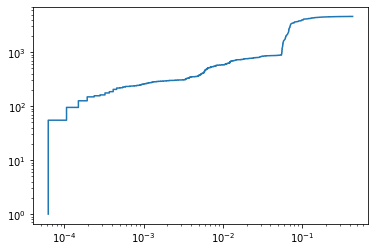

In [82]:
import statsmodels.api as sm # recommended import according to the docs

ecdf = sm.distributions.ECDF(gene_annotation_enrichment['perm_q'])

x = np.linspace(min(gene_annotation_enrichment['perm_q']), max(gene_annotation_enrichment['perm_q']),10000)
y = ecdf(x)
plt.step(x, y*gene_annotation_enrichment.shape[0])
plt.xscale('log')
plt.yscale('log')
#plt.axhline(1,color = 'r', linestyle = '--')
#plt.axvline(0.0032,color = 'r', linestyle = '--')
plt.show()

In [61]:
y[1:20]*gene_annotation_enrichment.shape[0]

array([ 55.,  95., 126., 149., 156., 162., 176., 186., 205., 217., 220.,
       227., 232., 233., 236., 237., 239., 242., 244.])

In [62]:
x[1:20]

array([0.00010608, 0.00014985, 0.00019361, 0.00023737, 0.00028113,
       0.00032489, 0.00036865, 0.00041241, 0.00045617, 0.00049993,
       0.00054369, 0.00058745, 0.00063121, 0.00067497, 0.00071873,
       0.00076249, 0.00080625, 0.00085001, 0.00089377])

In [28]:
gene_annotation_enrichment[(gene_annotation_enrichment['Count']>2) & 
                           (gene_annotation_enrichment['perm_q']<0.05)]

,Cluster,Annotation,Count,value,perm_p,perm_q
3505,28,ATP1A3,4,0.0,0.000002,0.008227
2357,21,GDF5,8,0.0,0.000002,0.004113
3511,28,CACNA1A,9,0.0,0.000002,0.002742
4328,35,HLA-DRB1,13,0.0,0.000002,0.002057
2333,21,DLL3,5,0.0,0.000002,0.001645
...,...,...,...,...,...,...
4564,36,RET,3,2588.0,0.004621,0.026714
4580,36,SMARCB1,3,2699.0,0.004820,0.027755
1310,10,WT1,3,3332.0,0.005950,0.032325
4606,36,WT1,3,3655.0,0.006527,0.035045


In [39]:
gard2gene['Cluster'] = [cluster_map[i] for i in gard2gene['GARD_ID']]

In [48]:
gene_enrichment_results = gard2gene.merge(gene_annotation_enrichment,left_on=["Cluster","Gene_Symbol"],right_on=["Cluster","Annotation"]).drop(["Annotation"],axis=1)

In [49]:
gene_enrichment_results.to_csv("../data/processed/gard_gene_enrichment_results.csv",index=False)

In [50]:
pharos_targets = pd.read_csv("../data/raw/pharos_all_target_ligands.csv")

In [56]:
pharos_targets.head()

,id,UniProt,Symbol,Ligand Name,Ligand Is Drug,Ligand SMILES,Ligand PubChem ID,Ligand ChEMBL ID,Ligand DrugCentral ID,Ligand Description,Preferred Term,UNII,Ligand Activity,Ligand Activity Type,Ligand Action,Ligand References,Ligand Reference Source,Ligand PubMed IDs
0,2725,Q96PD7,DGAT2,"US9296745, 21",0,O=C([C@@H]1CCCN(c2ccc3nc(-c4ccccc4F)[nH]c3n2)C...,117966738,CHEMBL4112431,NaN,NaN,NaN,NaN,6.46,IC50,NaN,"None, (2016) None:None:None",NaN,NaN
1,13083,P07339,CTSD,"N-((2S,3R)-1-(3,5-difluorophenyl)-3-hydroxy-4-...",0,CC(=O)N[C@@H](Cc1cc(F)cc(F)c1)[C@H](O)CN[C@H]1...,73355107,CHEMBL2408755,NaN,NaN,NaN,NaN,8.22,IC50,NaN,"Bioorg. Med. Chem. Lett., (2013) 23:16:4674",NaN,23856050
2,15267,P36544,CHRNA7,"(E)-3',5'-Dimethoxy-4-(2-triethylammoniumethyl...",0,CC[N+](CC)(CC)CCOc1ccc(/C=C/c2cc(OC)cc(OC)c2)c...,145990275,CHEMBL4287656,NaN,NaN,NaN,NaN,6.72,Ki,NaN,"J Med Chem, (2018) 61:23:10531",NaN,30403486
3,784,Q9GZT9,EGLN1,1-(6-Hydroxy-pyrimidin-4-yl)-8-(3-methyl-pyrid...,0,Cc1cccnc1CN1CCC2(CC1)C(=O)N(c1ccc(-c3ccc(-c4cc...,"49849231,136205832",CHEMBL2041169,NaN,NaN,NaN,NaN,9.70,IC50,NaN,"J. Med. Chem., (2012) 55:7:2945",NaN,22364528
4,13532,P11511,CYP19A1,7-(4-Acetylphenoxy)-4-(1H-imidazol-1-ylmethyl)...,0,CC(=O)c1ccc(Oc2ccc3c(Cn4ccnc4)cc(=O)oc3c2)cc1,51355974,CHEMBL1688908,NaN,NaN,NaN,NaN,6.53,IC50,NaN,"J. Med. Chem., (2011) 54:6:1613",NaN,21341743


In [51]:
pharos_uniprot = [i for i in pharos_targets['UniProt'].unique()]
mg = mygene.MyGeneInfo()
mg_uniprot = mg.querymany(pharos_uniprot, scopes='uniprot', fields='entrezgene', species='human',returnall=True)
entrez_counts = Counter([i.get('query') for i in mg_uniprot['out'] if i.get('entrezgene')])
uniprot2entrez = {}

for query in mg_uniprot['out']:
    if query.get('entrezgene'):
        if  query['query'] in uniprot2entrez:
            uniprot2entrez[query['query']].append(query['entrezgene'])
        else:
            uniprot2entrez[query['query']] = [query['entrezgene']]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2613...done.
Finished.
25 input query terms found dup hits:
	[('P36544', 2), ('P49674', 2), ('P34998', 2), ('Q86W56', 2), ('P0C869', 2), ('Q9NQU5', 2), ('Q59H18'
12 input query terms found no hit:
	['Q92753', 'P19835', 'Q6ZSR9', 'P59539', 'P57078', 'O75343', 'Q96P09', 'Q5SWA1', 'Q7RTR8', 'P01860',


In [57]:
unique_pharos_targets = pharos_targets[['UniProt','Symbol','Ligand Name','Ligand Is Drug','Ligand SMILES','Ligand PubChem ID','Ligand ChEMBL ID']].drop_duplicates()

In [52]:
entrez2uniprot={}
for i in uniprot2entrez:
    for entrez in uniprot2entrez[i]:
        entrez2uniprot[entrez] = i

In [55]:
gene_enrichment_results['UniProt'] = [entrez2uniprot.get(str(int(i))) for i in gene_enrichment_results['Gene_ID']]

In [59]:
enriched_disease_genes = gene_enrichment_results[gene_enrichment_results['perm_q']<=0.05]

In [60]:
enriched_disease_genes.merge(
    unique_pharos_targets[unique_pharos_targets['Ligand Is Drug']==1],on='UniProt'
).to_csv("../data/processed/enriched_genes_pharos.csv",index=False)

## Walk based enrichment


In [21]:
cluster_walk_annotation = pd.read_table("../data/processed/cluster_walk_annotations.txt")

In [22]:
cluster_walk_annotation

,Cluster,Disease,Annotation_Type,Annotation,Count
0,25,GARD:0008605,gene,51268,1
1,25,GARD:0008605,gene,956,1
2,25,GARD:0008605,gene,11232,1
3,25,GARD:0008605,SmallMolecule,PUBCHEM:24462,3
4,25,GARD:0008605,gene,4487,2
...,...,...,...,...,...
16082847,13,GARD:0010510,gene,64397,1
16082848,13,GARD:0010510,SmallMolecule,CHEMBL:CHEMBL452630,1
16082849,13,GARD:0010510,gene,25819,1
16082850,13,GARD:0010510,gene,5605,1


In [23]:
N = len(set(cluster_walk_annotation['Cluster']))

In [24]:
TF = cluster_walk_annotation.groupby(['Cluster','Annotation']).agg({'Count':sum}).reset_index()

In [25]:
cluster_count = cluster_walk_annotation.groupby(['Cluster']).agg({'Count':sum}).reset_index()


In [26]:
document_freq = cluster_walk_annotation[['Cluster','Annotation']].drop_duplicates().groupby('Annotation').size().reset_index()

In [27]:
document_freq.columns

Index(['Annotation', 0], dtype='object')

In [28]:
TF = TF.merge(cluster_count,on=['Cluster'])
TF['tf'] = TF['Count_x']/TF['Count_y']

In [29]:
TF = TF.merge(document_freq)

In [30]:
TF['TF-idf'] = TF['tf']*np.log(N/TF[0])

In [178]:
TF[TF['Annotation']=='CHEMBL:CHEMBL3917854']

,Cluster,Annotation,Count_x,Count_y,tf,0,TF-idf
1460146,1,CHEMBL:CHEMBL3917854,3,818723,0.000004,1,0.000013


In [31]:
TF_with_types = cluster_walk_annotation[['Annotation_Type','Annotation']].drop_duplicates().merge(TF)

In [32]:
TF_with_types['TF-idf'][TF_with_types['TF-idf']>0].describe()

count    1.906100e+06
mean     2.525442e-06
std      3.945969e-06
min      1.719006e-08
25%      8.035470e-07
50%      1.778088e-06
75%      3.046712e-06
max      6.176673e-04
Name: TF-idf, dtype: float64

In [155]:
TF_with_types

,Annotation_Type,Annotation,Cluster,Count_x,Count_y,tf,0,TF-idf
0,gene,51268,0,11,527352,0.000021,37,0.000000
1,gene,51268,1,18,818723,0.000022,37,0.000000
2,gene,51268,2,25,1593885,0.000016,37,0.000000
3,gene,51268,3,18,834922,0.000022,37,0.000000
4,gene,51268,4,29,1191135,0.000024,37,0.000000
...,...,...,...,...,...,...,...,...
2467792,SmallMolecule,CHEMBL:CHEMBL439007,13,1,966222,0.000001,1,0.000004
2467793,SmallMolecule,CHEMBL:CHEMBL3317482,13,1,966222,0.000001,1,0.000004
2467794,SmallMolecule,CHEMBL:CHEMBL3234591,13,1,966222,0.000001,1,0.000004
2467795,SmallMolecule,CHEMBL:CHEMBL3704345,13,1,966222,0.000001,1,0.000004


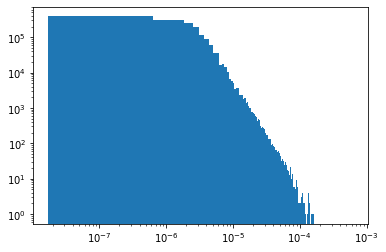

In [75]:
plt.hist(TF_with_types['TF-idf'][TF_with_types['TF-idf']>0],bins=1000)
plt.xscale('log')
plt.yscale('log')

plt.show()#.describe()

In [76]:
import statsmodels.api as sm # recommended import according to the docs

TF_nonzero = TF_with_types[TF_with_types['TF-idf']>0]
TF_ecdf = sm.distributions.ECDF(TF_nonzero['TF-idf'])


In [254]:
percentiles = [TF_ecdf(i) for i in TF_nonzero.loc[:,'TF-idf']]

In [258]:
TF_nonzero.loc[:,'percentiles'] = percentiles

In [284]:
10**(-np.linspace(0.5,5.0,10))

array([3.16227766e-01, 1.00000000e-01, 3.16227766e-02, 1.00000000e-02,
       3.16227766e-03, 1.00000000e-03, 3.16227766e-04, 1.00000000e-04,
       3.16227766e-05, 1.00000000e-05])

In [259]:
top_percentile_list = []
for thresh in (1 - 10**(-np.linspace(0.5,5.0,10))):
    top_tf_counts = TF_nonzero[(TF_nonzero['percentiles']>thresh)][['Cluster','Annotation_Type','Annotation']].groupby(['Annotation_Type','Cluster']).size().reset_index()
    top_tf_counts['threshold'] = 1 - thresh
    top_percentile_list.append(top_tf_counts)
    
top_percentile_df = pd.concat(top_percentile_list).reset_index().drop("index",axis=1)

In [260]:
top_percentile_df

,Annotation_Type,Cluster,0,threshold
0,GO,0,1649,0.316228
1,GO,1,3396,0.316228
2,GO,2,396,0.316228
3,GO,3,2134,0.316228
4,GO,4,1486,0.316228
...,...,...,...,...
806,gene,5,2,0.000010
807,gene,7,1,0.000010
808,gene,15,1,0.000010
809,gene,22,3,0.000010


In [261]:
top_percentile_df.columns = ["Annotation Type","Cluster","Count","Tf-idf Percentile"]
top_percentile_df

,Annotation Type,Cluster,Count,Tf-idf Percentile
0,GO,0,1649,0.316228
1,GO,1,3396,0.316228
2,GO,2,396,0.316228
3,GO,3,2134,0.316228
4,GO,4,1486,0.316228
...,...,...,...,...
806,gene,5,2,0.000010
807,gene,7,1,0.000010
808,gene,15,1,0.000010
809,gene,22,3,0.000010


In [276]:
top_percentile_df[(top_percentile_df['Cluster']==0) & (top_percentile_df['Annotation Type']=='gene')]

,Annotation Type,Cluster,Count,Tf-idf Percentile
111,gene,0,74,0.316228
259,gene,0,14,0.100000
406,gene,0,4,0.031623
541,gene,0,1,0.010000


In [281]:
TF_nonzero[(TF_nonzero['Cluster']==0) & 
           (TF_nonzero['Annotation_Type']=='gene') &
          (TF_nonzero['percentiles']>=0.99)]

,Annotation_Type,Annotation,Cluster,Count_x,Count_y,tf,0,TF-idf,percentiles,inv_percentile
1999879,gene,284047,0,5,527352,0.000009,7,0.000016,0.990284,0.009716


In [296]:
log_bins=np.flip(10**(-np.linspace(1,5.5,10)))

In [297]:
log_bins

array([3.16227766e-06, 1.00000000e-05, 3.16227766e-05, 1.00000000e-04,
       3.16227766e-04, 1.00000000e-03, 3.16227766e-03, 1.00000000e-02,
       3.16227766e-02, 1.00000000e-01])

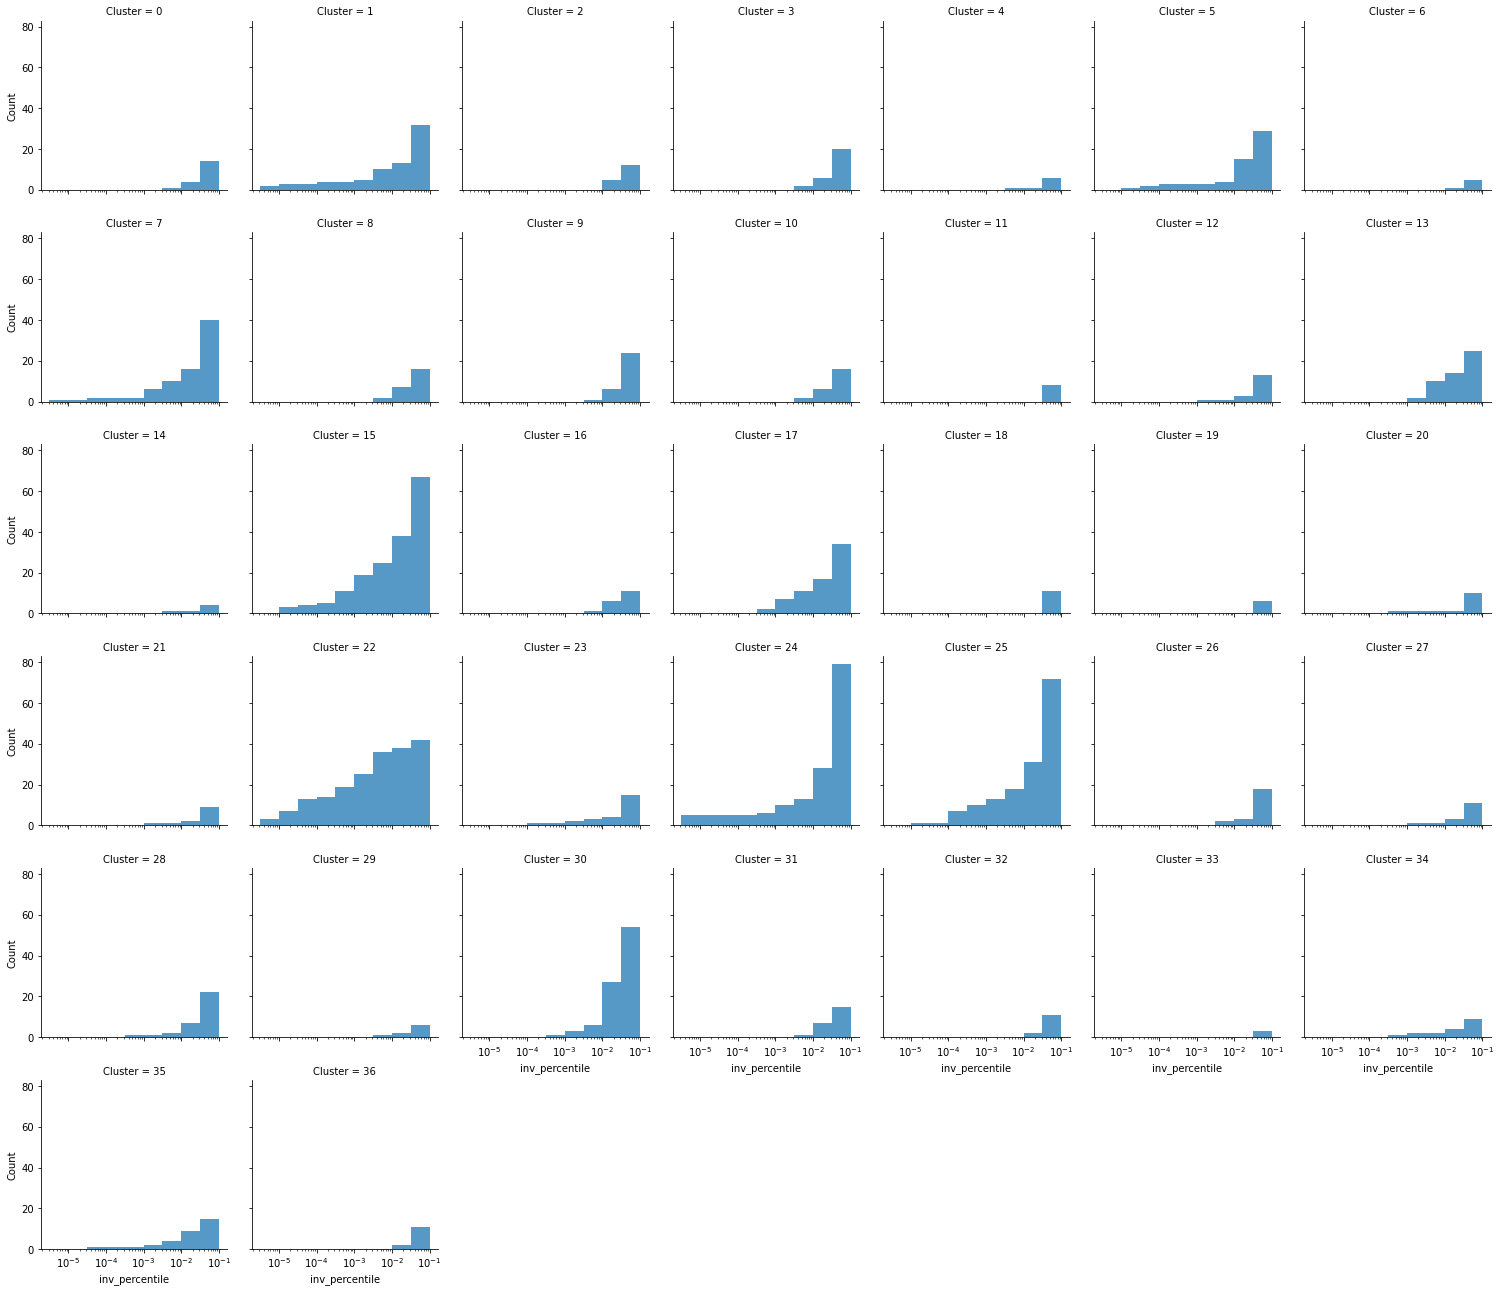

In [300]:
g = sns.FacetGrid(TF_nonzero[(TF_nonzero['Annotation_Type']=="gene") & (TF_nonzero['percentiles']>=0.9)], col='Cluster',col_wrap=7)
g.map(sns.histplot, "inv_percentile",cumulative=True,bins=log_bins).set(xscale='log')

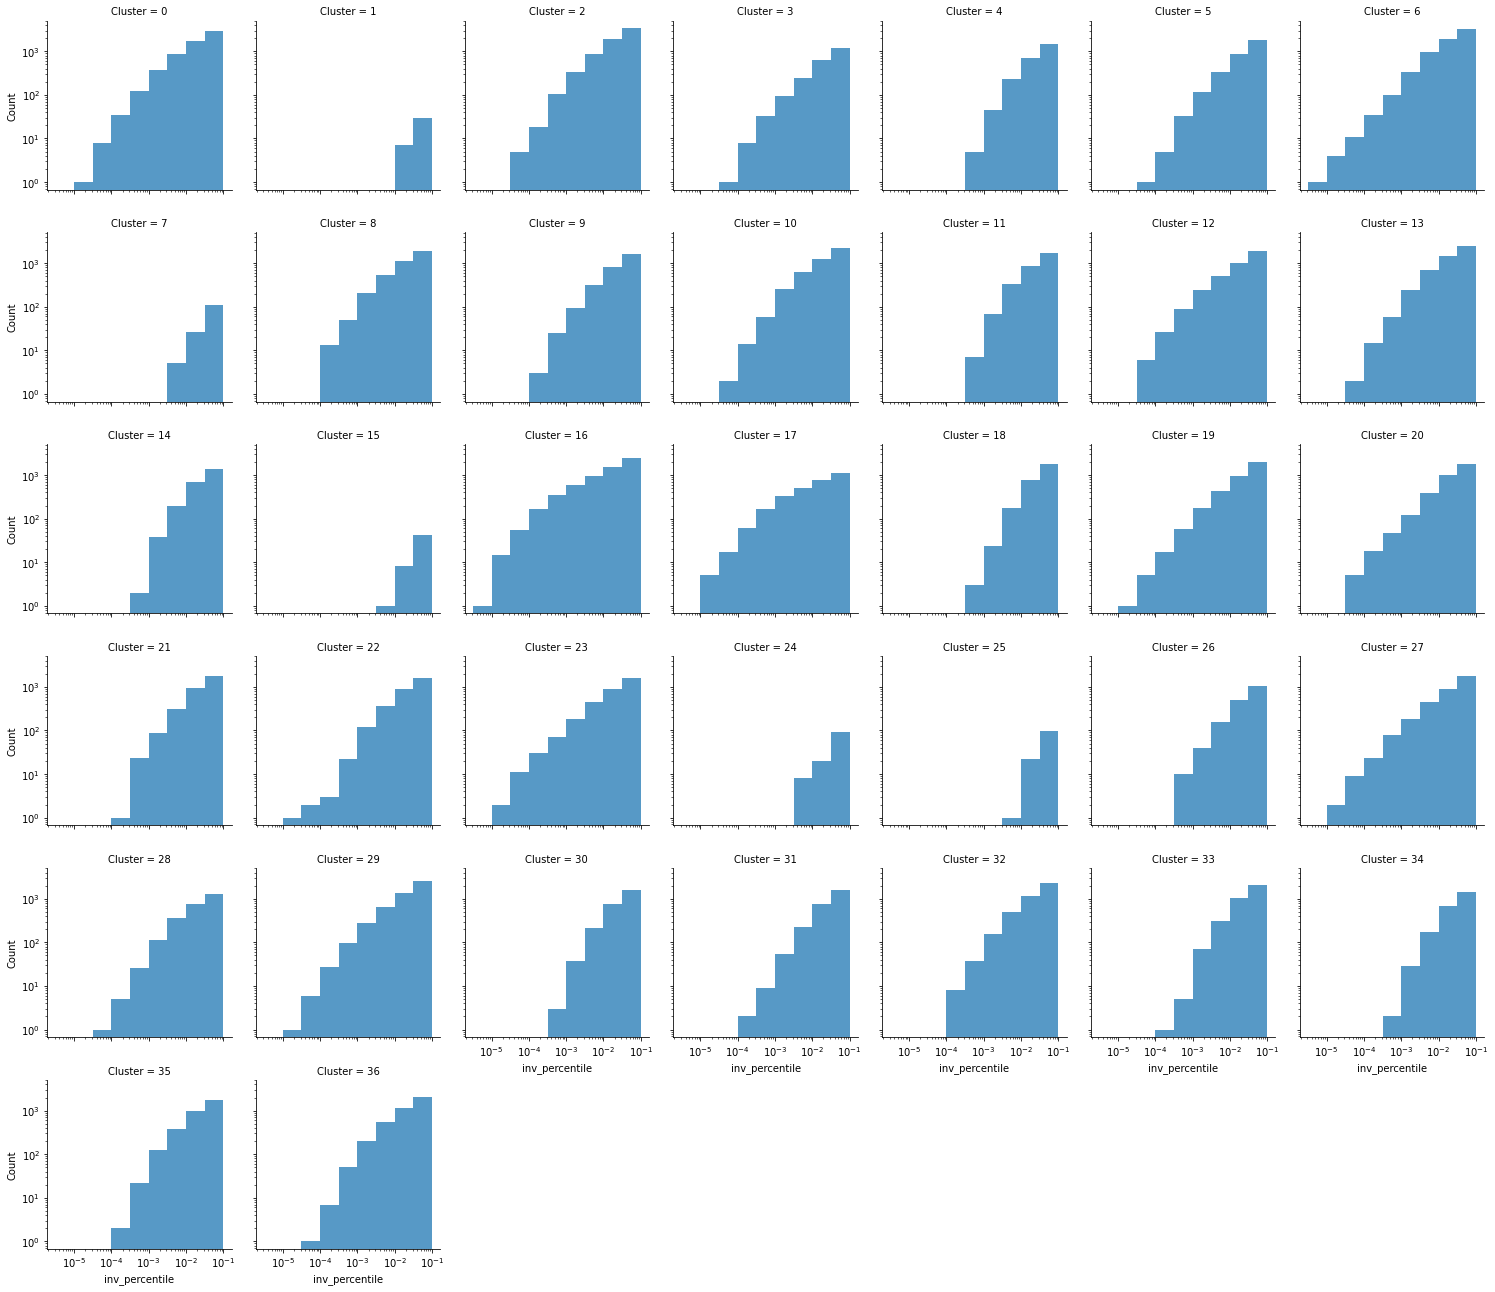

In [304]:
g = sns.FacetGrid(TF_nonzero[(TF_nonzero['Annotation_Type']=="HPO") & (TF_nonzero['percentiles']>=0.9)], col='Cluster',col_wrap=7)
g.map(sns.histplot, "inv_percentile",cumulative=True,bins=log_bins).set(xscale='log',yscale='log')

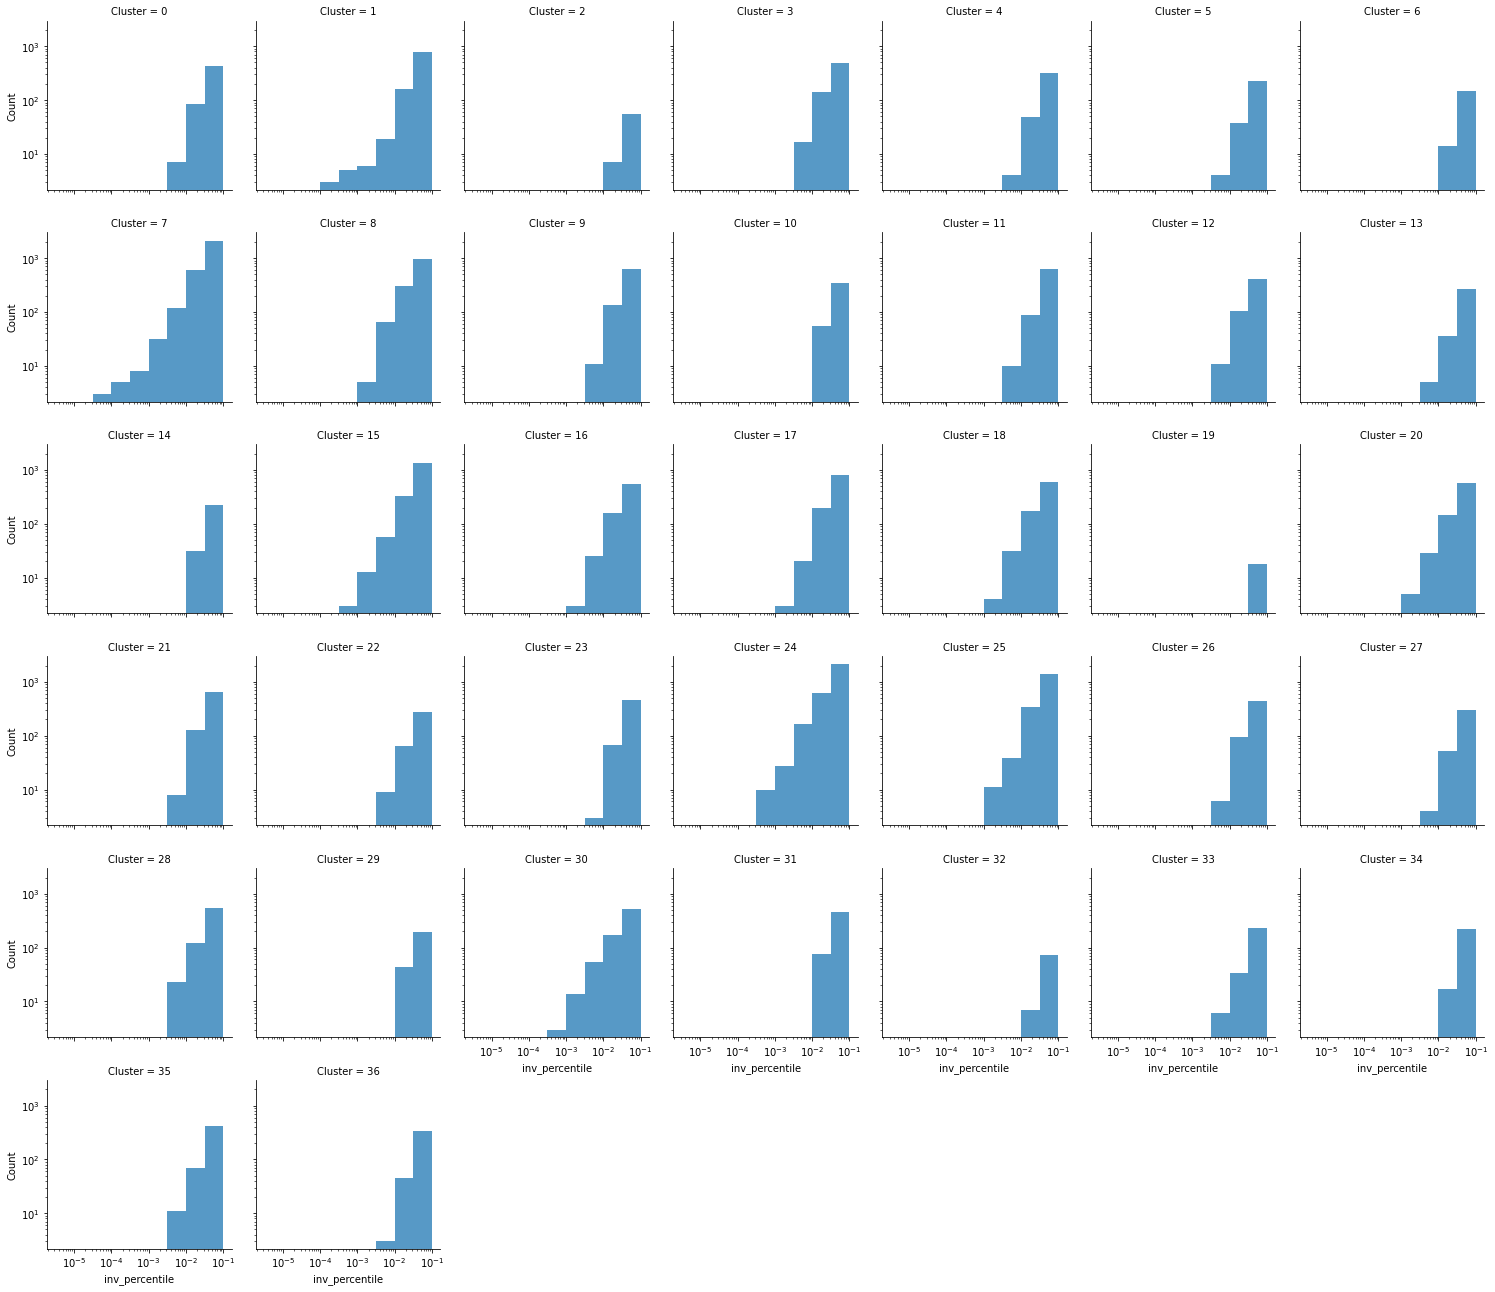

In [305]:
g = sns.FacetGrid(TF_nonzero[(TF_nonzero['Annotation_Type']=="GO") & (TF_nonzero['percentiles']>=0.9)], col='Cluster',col_wrap=7)
g.map(sns.histplot, "inv_percentile",cumulative=True,bins=log_bins).set(xscale='log',yscale='log')

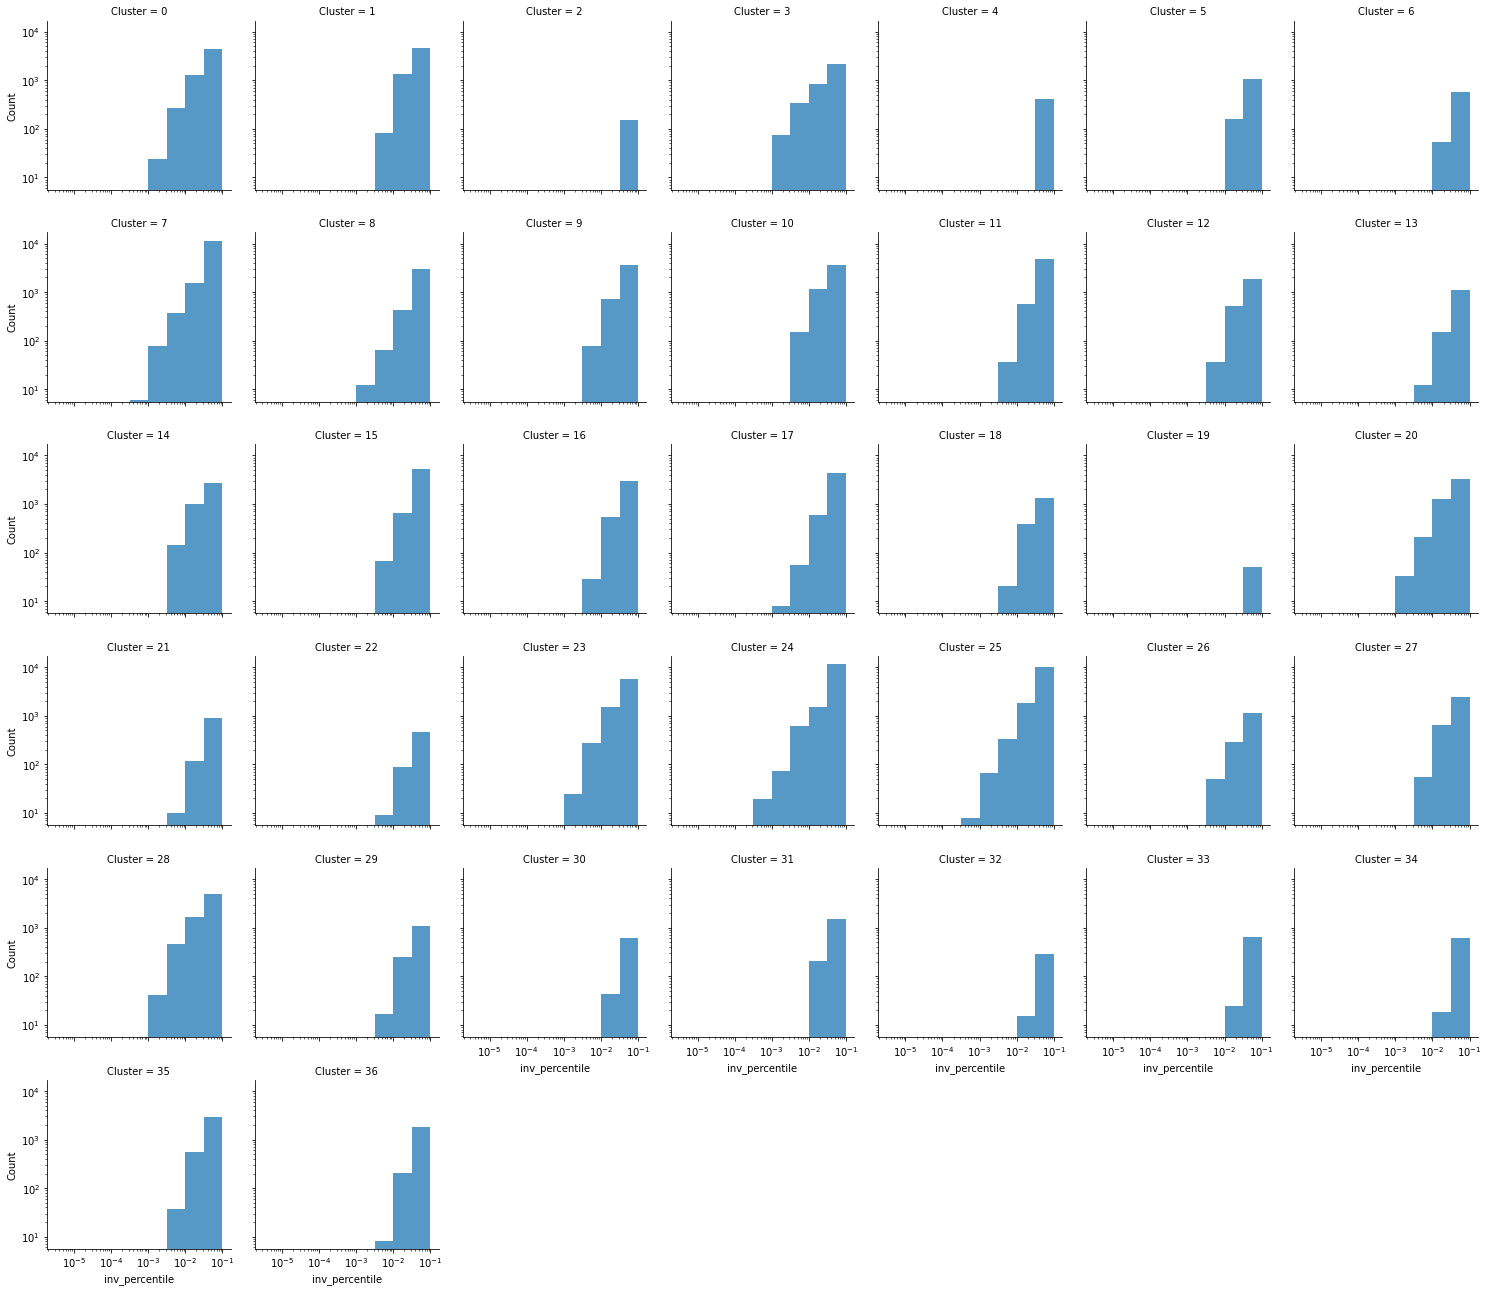

In [306]:
g = sns.FacetGrid(TF_nonzero[(TF_nonzero['Annotation_Type']=="SmallMolecule") & (TF_nonzero['percentiles']>=0.9)], col='Cluster',col_wrap=7)
g.map(sns.histplot, "inv_percentile",cumulative=True,bins=log_bins).set(xscale='log',yscale='log')

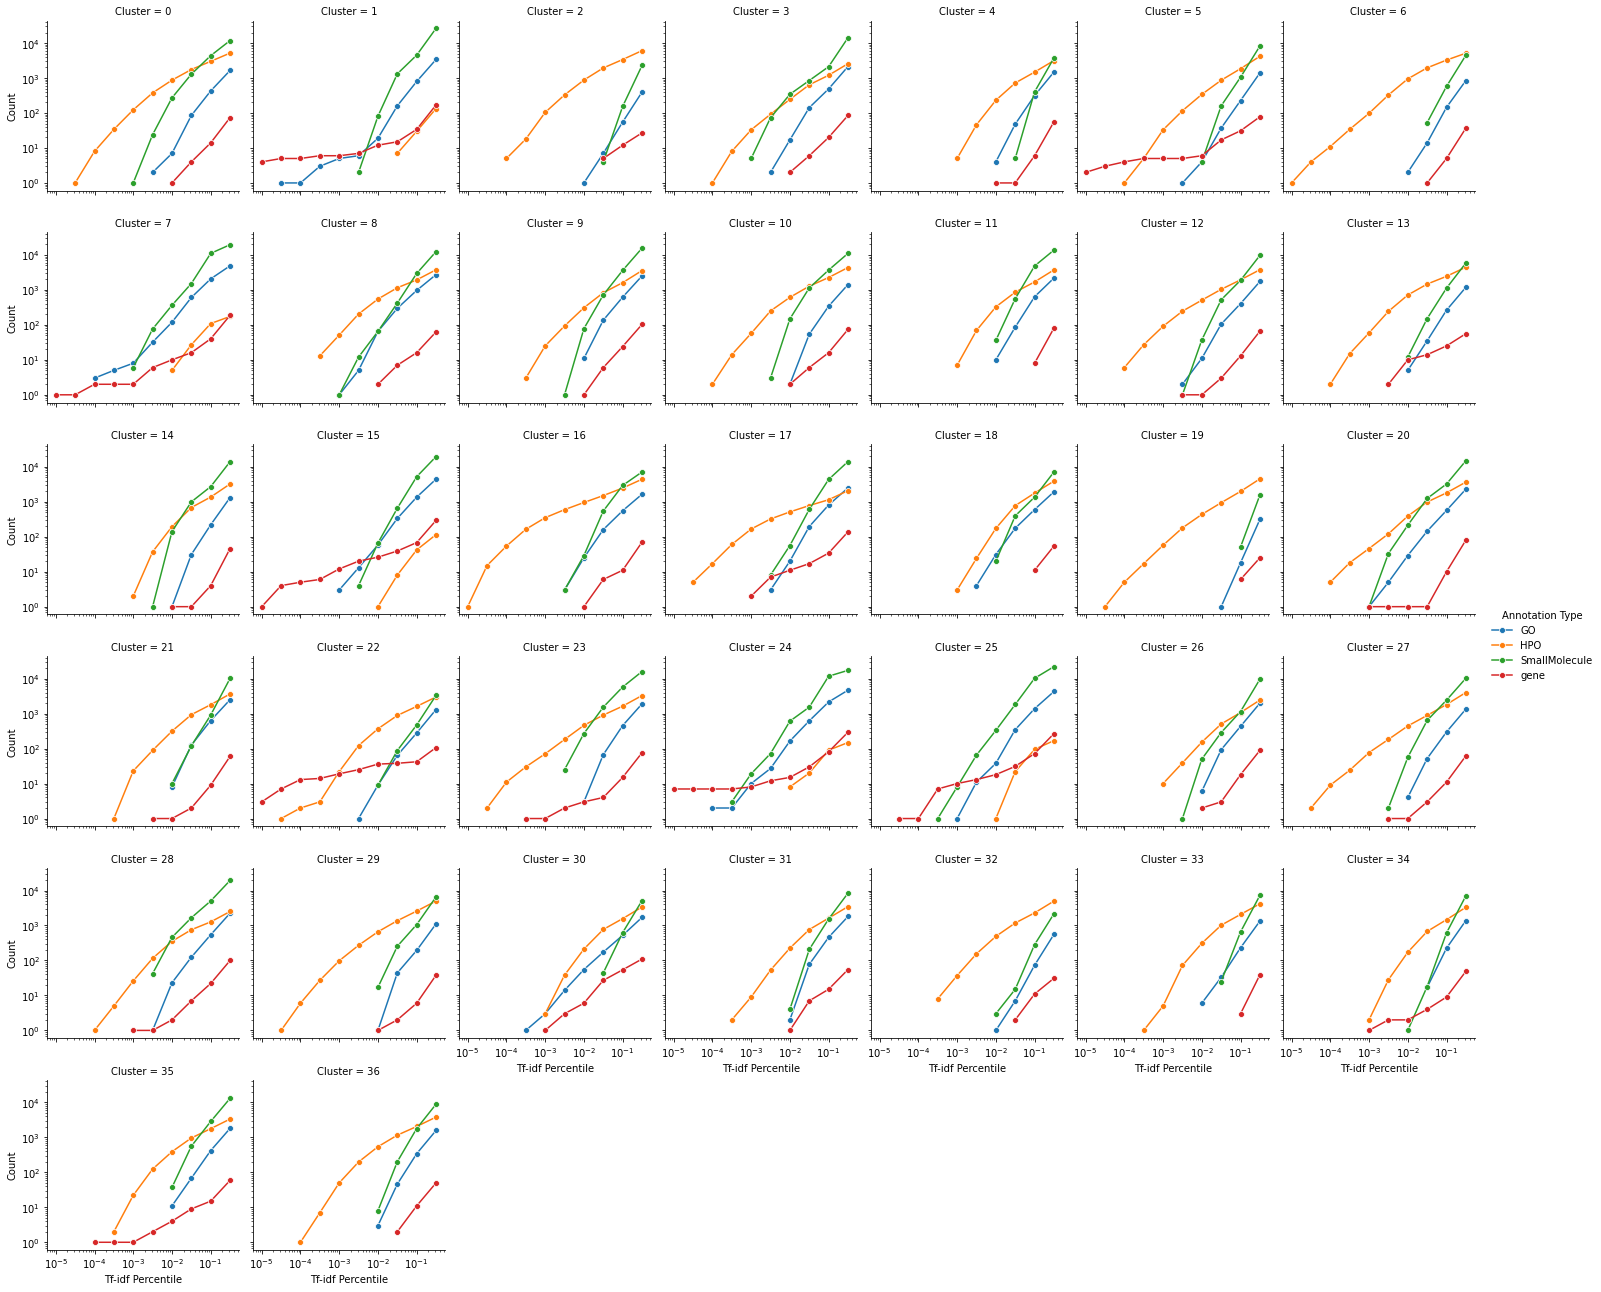

In [307]:
g = sns.FacetGrid(top_percentile_df, hue="Annotation Type",col='Cluster',col_wrap=7)
g.map(sns.lineplot, "Tf-idf Percentile","Count",markers=True,style=0).set(yscale='log',xscale='log',xticks=[0.00001,0.0001,0.001,0.01,0.1])#,yscale='log')
g.add_legend()

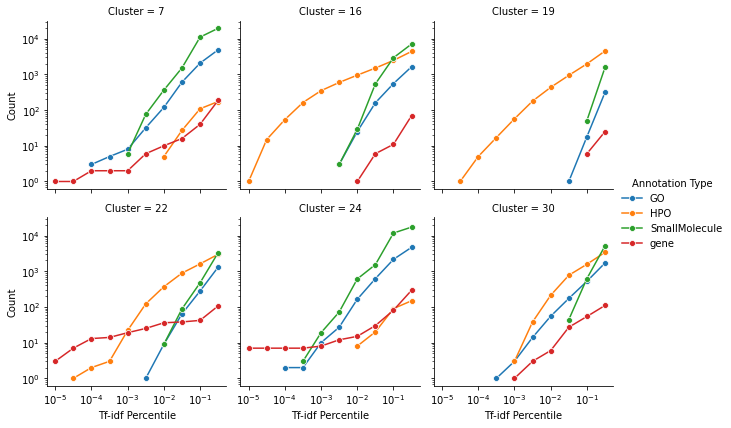

In [312]:
g = sns.FacetGrid(top_percentile_df[top_percentile_df['Cluster'].isin([22,7,16,19,24,30])], hue="Annotation Type",col='Cluster',col_wrap=3)
g.map(sns.lineplot, "Tf-idf Percentile","Count",markers=True,style=0).set(yscale='log',xscale='log',xticks=[0.00001,0.0001,0.001,0.01,0.1])#,yscale='log')
g.add_legend()